In [1]:
import geopandas as gpd
from dask.distributed import Client, LocalCluster
from dask import delayed, dataframe as dd
from tqdm import tqdm
import dask
import dask_geopandas as dgp
import matplotlib.pyplot as plt
from shapely.geometry import box
from tqdm import tqdm
from shapely.geometry import Point, Polygon
import libpysal
import pandas as pd
from libpysal.weights import W
import momepy
import pickle
import contextily as ctx

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
place = "glasgow"
local_crs = 27700

In [3]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='70GB')

client = Client(daskCluster)

client

2023-11-27 02:20:09,050 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-11-27 02:20:09,052 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-11-27 02:20:09,055 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-11-27 02:20:09,059 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-11-27 02:20:09,062 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-11-27 02:20:09,065 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-11-27 02:20:09,069 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-11-27 02:20:09,072 - d

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 250.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36115,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 250.47 GiB
Comm: tcp://127.0.0.1:39777,Total threads: 2
Dashboard: http://127.0.0.1:42791/status,Memory: 31.31 GiB
Nanny: tcp://127.0.0.1:37325,


In [4]:
tessellation = gpd.read_parquet(f"./output/{place}/tessellation_p1.pq").to_crs(local_crs)
buildings = gpd.read_parquet(f"./output/{place}/buildings_p1.pq").to_crs(local_crs)
streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)

/tmp/ipykernel_24159/3257141034.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)


In [5]:
# Load your GeoDataFrame
gdf = tessellation

# Calculate the extent of the dataset
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]

# Modify the create_grid function to include tqdm
def create_grid(bounds, width, height):
    minx, miny, maxx, maxy = bounds
    grid = []
    x_range = range(int((maxx - minx) / width)+1)
    y_range = range(int((maxy - miny) / height)+1)

    for x in tqdm(x_range, desc="Creating Grid"):
        x_coord = minx + x * width
        for y in y_range:
            y_coord = miny + y * height
            grid.append(box(x_coord, y_coord, x_coord + width, y_coord + height))

    return grid

grid_squares = create_grid(bounds, 14000, 14000) 

# Convert to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_squares)

Creating Grid: 100%|██████████| 6/6 [00:00<00:00, 1427.28it/s]


In [6]:
tessellation.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

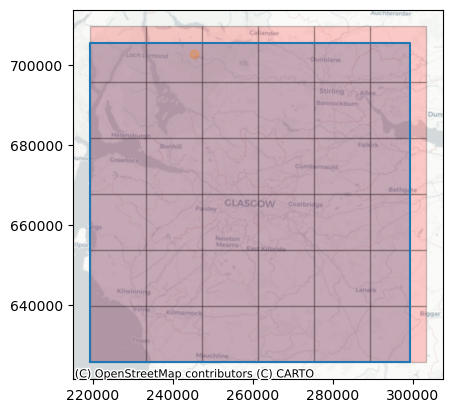

In [7]:


# Example: Assuming gdf is your GeoDataFrame
# gdf = gpd.read_file('your_file.geojson') or any other source

# Get the total bounds
bounds = gdf.total_bounds

# Create a polygon from the bounds
# The order of points is: bottom-left, top-left, top-right, bottom-right
polygon = Polygon([(bounds[0], bounds[1]), (bounds[0], bounds[3]), 
                   (bounds[2], bounds[3]), (bounds[2], bounds[1])])

# Optional: Plotting
fig, ax = plt.subplots()
x,y = polygon.exterior.xy
plt.plot(x, y)
plt.fill(x, y, alpha=0.3)
grid_gdf.plot(ax=ax, color='red', alpha=0.2, edgecolor='black')
tessellation[tessellation["uID"] == 0].geometry.centroid.plot(ax=ax, alpha = 0.3)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=tessellation.crs)
plt.show()

In [8]:
grid_gdf.to_parquet(f"output/{place}/grid_gdf.pq")

In [9]:
grid_gdf["uID"] = grid_gdf.index

In [10]:
def find_neighbours(tessellation, cell):
    # Get 'not disjoint' countries
    neighbours = tessellation[~tessellation.geometry.disjoint(cell.geometry)].uID.tolist()
    # Remove own uID of the cell from the list
    neighbours_list = [uID for uID in neighbours if cell.uID != uID]
    return neighbours_list

out = []

for index, cell in grid_gdf.iterrows():
    # Add the delayed task to the current batch
    result = find_neighbours(grid_gdf, cell)
    out.append(result)

In [11]:
grid_gdf["touching"] = out

In [12]:
# Step 1: Calculate centroids
tessellation['centroid'] = tessellation.geometry.centroid

# Step 2: Convert centroids to a new GeoDataFrame
centroids = gpd.GeoDataFrame(tessellation, geometry='centroid')

# Step 3: Perform spatial join
joined_gdf = gpd.sjoin(centroids, grid_gdf, how='inner', op='intersects')

# Step 4: Group original polygons based on the join
grouped_gdf = tessellation.merge(joined_gdf[['centroid', 'index_right']], left_on='centroid', right_on='centroid')


/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_24159/2368018611.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: None

  joined_gdf = gpd.sjoin(centroids, grid_gdf, how='inner', op='intersects')


In [13]:

# Assuming you have a GeoDataFrame 'grouped_gdf' and you're grouping by some column 'grouping_column'
grouped = grouped_gdf.groupby('index_right')

cells_in_region = {region:set() for region in grid_gdf.uID}


In [14]:
# Extracting the uID lists for each group
for group_name, group in grouped:
    cells_in_region[group_name] = set(group['uID'].tolist())

In [15]:
# Assuming 'grouped_gdf' is your GeoDataFrame and it's correctly defined
buffered_tessellation = grouped_gdf.copy()  # Create a copy to retain the original data

# Apply a buffer of 50 units to each geometry
buffered_tessellation["geometry"] = buffered_tessellation["geometry"].buffer(100)


In [16]:
cells_in_expanded_region = cells_in_region.copy()

for index, region in tqdm(grid_gdf.iterrows(), total=grid_gdf.shape[0]):
    expanded_cells = buffered_tessellation[buffered_tessellation['index_right'].isin(region.touching)]

    intersection_rows = expanded_cells[expanded_cells.intersects(region.geometry.boundary)]
    
    cells_in_expanded_region[index] = cells_in_region[index].union(set(intersection_rows.uID.tolist()))
    

100%|██████████| 36/36 [00:02<00:00, 13.59it/s]


In [17]:
expanded_cell_gdf = tessellation[tessellation['uID'].isin(list(cells_in_expanded_region[15]))]

test = libpysal.weights.fuzzy_contiguity(expanded_cell_gdf, tolerance=0.05, buffering=True, drop=True, buffer=5, ids="uID", silence_warnings=True)


/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/libpysal/weights/util.py:1674: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.drop(columns=["_buffer"], inplace=True)


In [18]:
list_of_weights = []

for index, expanded_region in tqdm(grid_gdf.iterrows(), total=grid_gdf.shape[0]):
    expanded_cell_gdf = tessellation[tessellation['uID'].isin(list(cells_in_expanded_region[index]))]
    
    list_of_weights.append(libpysal.weights.fuzzy_contiguity(expanded_cell_gdf, tolerance=0.05, buffering=True, drop=True, buffer=5, ids="uID", silence_warnings=True))


  0%|          | 0/36 [00:00<?, ?it/s]/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/libpysal/weights/util.py:1674: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.drop(columns=["_buffer"], inplace=True)
  3%|▎         | 1/36 [00:01<00:45,  1.31s/it]/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geod

In [19]:
adjlist_combined = None
for index, weight in tqdm(enumerate(list_of_weights), total= len(list_of_weights)):
    
    adjlist = list_of_weights[index].to_adjlist()
    
    if index == 0:
        adjlist_combined = adjlist
    
    else:
        adjlist_combined = pd.concat([adjlist_combined, adjlist])

100%|██████████| 36/36 [00:03<00:00,  9.04it/s]


In [20]:
unique_ids = tessellation['uID'].unique().tolist()

In [21]:
uID_neighbours = {uID: set() for uID in unique_ids}

In [22]:
adjlist_combined

,focal,neighbor,weight
0,416563.0,417742.0,1.0
1,416563.0,420094.0,1.0
2,416563.0,420683.0,1.0
3,416563.0,429733.0,1.0
4,416563.0,432789.0,1.0
...,...,...,...
27482,416475.0,216361.0,1.0
27483,416475.0,346419.0,1.0
27484,416475.0,371064.0,1.0
27485,416475.0,411176.0,1.0


In [23]:
for index, row in adjlist_combined.iterrows():
    uID_neighbours[row["focal"]].add(row["neighbor"])

In [24]:
three_queen_region = {}
for region in tqdm(cells_in_region):
    cells_to_search = cells_in_region[region]
    output = cells_in_region[region]
    for i in range(5):
        cells_found_in_current_iteration = set()
        
        for cell in cells_to_search:
            cells_found_in_current_iteration = cells_found_in_current_iteration.union(uID_neighbours[cell])
        
        cells_to_search = cells_found_in_current_iteration.difference(output)
        
        output = output.union(cells_found_in_current_iteration)
        
    three_queen_region[region] = output

100%|██████████| 36/36 [08:41<00:00, 14.48s/it]


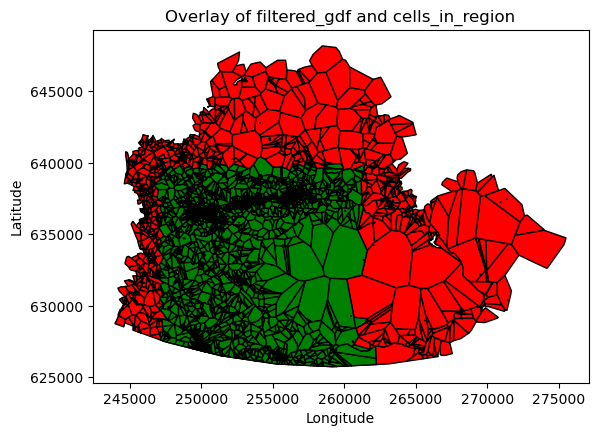

In [25]:
filtered_gdf2 = tessellation[tessellation['uID'].isin(cells_in_region[12])]
filtered_gdf = tessellation[tessellation['uID'].isin(three_queen_region[12])]

import matplotlib.pyplot as plt

# Create a plot
fig, ax = plt.subplots()

# Plot the first GeoDataFrame


# Plot the second GeoDataFrame


filtered_gdf.plot(ax=ax, color='red', edgecolor='k', alpha=1)

filtered_gdf2.plot(ax=ax, color='green', edgecolor='k', alpha=1)


# Customize the plot (optional)
ax.set_title("Overlay of filtered_gdf and cells_in_region")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [26]:
with open(f"output/{place}/three_queen_region.pq", 'wb') as file:
    pickle.dump(three_queen_region, file)

In [27]:
dist200 = libpysal.weights.DistanceBand.from_dataframe(buildings, 200, ids='uID')

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6387 disconnected components.
 There are 1353 islands with ids: 5, 43, 94, 96, 156, 204, 233, 234, 245, 255, 260, 279, 336, 455, 474, 484, 496, 513, 527, 546, 557, 570, 617, 655, 740, 756, 814, 817, 837, 852, 877, 878, 884, 1108, 1584, 2400, 2412, 2814, 3356, 3630, 3889, 4021, 4900, 4925, 5420, 5694, 5838, 5872, 5912, 8037, 12311, 12359, 12523, 12606, 12964, 13063, 13216, 13371, 14739, 14964, 15237, 15761, 15989, 16556, 16683, 16820, 17401, 17528, 18284, 18401, 18820, 19245, 19288, 20310, 20511, 20825, 20836, 20872, 21101, 21331, 21683, 21835, 21837, 21893, 22775, 23511, 23572, 23817, 24597, 26029, 26351, 27125, 27973, 28571, 29961, 30216, 31074, 31249, 31389, 31628, 31873, 32150, 32656, 32763, 33287, 33739, 33747, 34503, 34999, 35004, 35870, 36030, 36078, 36178, 36638, 36702, 36860, 37246, 37327, 37542, 375

In [28]:
dist200_adjlist = dist200.to_adjlist()


## Morphometrics

In [29]:
buildings_local_out_combined = pd.DataFrame()
buildings_dist200_combined = pd.DataFrame()
tessellation_out_combined = pd.DataFrame()

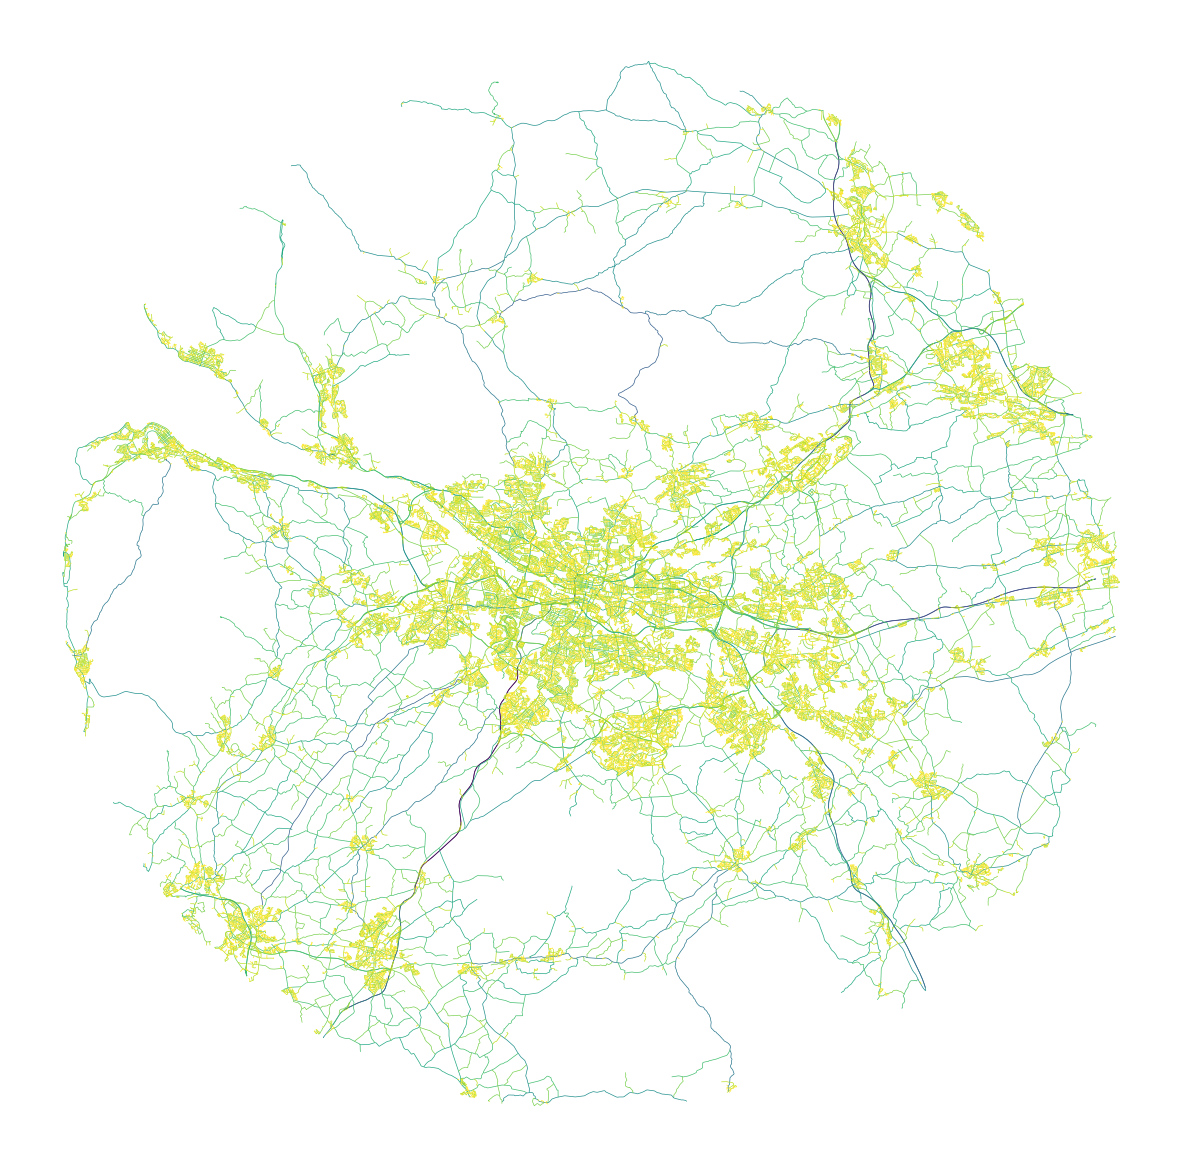

In [30]:
continuity = momepy.COINS(streets)

stroke_attr = continuity.stroke_attribute()

stroke_gdf = continuity.stroke_gdf()

stroke_gdf.plot(stroke_gdf.length,
                figsize=(15, 15),
                cmap="viridis_r",
                linewidth=.5,
                scheme="headtailbreaks"
               ).set_axis_off()

In [31]:
stroke_gdf["length"] = stroke_gdf.length

In [44]:
## Create Weights

for cell_index in tqdm(three_queen_region):
    
    filtered_df = adjlist_combined[
            adjlist_combined['focal'].isin(three_queen_region[cell_index]) & 
            adjlist_combined['neighbor'].isin(three_queen_region[cell_index])
        ]

    filtered_dist200_df = dist200_adjlist[
        dist200_adjlist['focal'].isin(three_queen_region[cell_index]) & 
        dist200_adjlist['neighbor'].isin(three_queen_region[cell_index])
    ]

    queen_1 = W.from_adjlist(filtered_df)

    queen_3 = momepy.sw_high(k=3, weights=queen_1)

    dist200 = W.from_adjlist(filtered_dist200_df)

    buildings_local = buildings[buildings['uID'].isin(three_queen_region[cell_index])]
    buildings_local_dist200 = buildings[buildings['uID'].isin(three_queen_region[cell_index])]

    dist200_buildings_uIDs = set(dist200_adjlist[dist200_adjlist['focal'].isin(three_queen_region[cell_index])]["neighbor"]).union(three_queen_region[cell_index])

    dist200 = W.from_adjlist(dist200_adjlist[
            dist200_adjlist['focal'].isin(dist200_buildings_uIDs) &
            dist200_adjlist['neighbor'].isin(dist200_buildings_uIDs)
        ])

    buildings_dist200 = buildings[buildings["uID"].isin(dist200_buildings_uIDs)]

    buildings_dist200["buildings_neighbours_200"] = momepy.Neighbors(buildings_dist200, dist200, 'uID', weighted=True).series

    buildings_out = buildings_dist200[buildings_dist200["uID"].isin(cells_in_region[cell_index])]
    
    queen_3_adjlist = queen_3.to_adjlist()

    # Get unique values from both columns
    unique_focal = queen_3_adjlist['focal'].unique()
    unique_neighbor = queen_3_adjlist['neighbor'].unique()

    # Combine and get unique values across both columns
    all_unique_values = pd.unique(pd.concat([pd.Series(unique_focal), pd.Series(unique_neighbor)]))
    
    tessellation_out = tessellation[tessellation["uID"].isin(all_unique_values)]
    
    ### Building Area
    buildings_local['building_area'] = momepy.Area(buildings_local).series
    tessellation_out['tess_area'] = momepy.Area(tessellation_out).series
    
    tessellation_out["tessellation_neighbours"] = momepy.Neighbors(tessellation_out, queen_3, 'uID', weighted=True).series
    
    buildings_local_scattered = client.scatter(buildings_local)
    streets_scattered = client.scatter(streets)
    tessellation_scattered = client.scatter(tessellation_out)

    dist200_scattered = client.scatter(dist200)
    queen_1_scattered = client.scatter(queen_1)
    queen_3_scattered = client.scatter(queen_3)
    
    buildings_local_out = buildings_local
    
    # Assuming buildings_local_scattered is a GeoDataFrame and queen_1 is defined

    jobs_names = ['building_circular_compactness', 'building_elongation', 'building_squareness', 'building_eri', 'building_orientation', "building_neighbour_dist", "building_neighbourhood_interbuilding_distance"]

    jobs = [dask.delayed(momepy.CircularCompactness)(buildings_local_scattered), 
            dask.delayed(momepy.Elongation)(buildings_local_scattered), 
            dask.delayed(momepy.Squareness)(buildings_local_scattered),
            dask.delayed(momepy.EquivalentRectangularIndex)(buildings_local_scattered), 
            dask.delayed(momepy.Orientation)(buildings_local_scattered), 
            dask.delayed(momepy.NeighborDistance)(buildings_local_scattered, queen_1_scattered, 'uID'), 
            dask.delayed(momepy.MeanInterbuildingDistance)(buildings_local_scattered, queen_1_scattered, 'uID', 3)]

    jobs_out = dask.compute(jobs)

    # Assign the results back to the buildings_local GeoDataFrame
    for index, field_name in enumerate(jobs_names):
        buildings_local_out[field_name] = jobs_out[0][index].series
        
    buildings_local_scattered = client.scatter(buildings_local_out)

    # Assuming buildings_local_scattered is a GeoDataFrame and queen_1 is defined

    jobs_names = ["tess_convexity", "tess_covered_area", "tess_orientation"]

    jobs = [dask.delayed(momepy.Convexity)(tessellation_scattered), 
            dask.delayed(momepy.CoveredArea)(tessellation_scattered, queen_1_scattered, "uID"),
            dask.delayed(momepy.Orientation)(tessellation_scattered)]

    jobs_out = dask.compute(jobs)

    # Assign the results back to the buildings_local GeoDataFrame
    for index, field_name in enumerate(jobs_names):
        tessellation_out[field_name] = jobs_out[0][index].series

    tessellation_scattered = client.scatter(tessellation_out)
    
    # Assuming buildings_local_scattered is a GeoDataFrame and queen_1 is defined

    jobs_names = ['building_circular_compactness_weight', 'building_elongation_weight', 'building_squareness_weight', 'building_eri_weight', "building_neighbour_dist_weight", "building_neighbourhood_interbuilding_distance_weight", 'building_orientation_weight']

    jobs = [dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_circular_compactness',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_elongation',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_squareness',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_eri',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_neighbour_dist',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_neighbourhood_interbuilding_distance',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_orientation',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID')]

    jobs_out = dask.compute(*jobs)

    # Assign the results back to the buildings_local GeoDataFrame
    for index, field_name in enumerate(jobs_names):
        buildings_local_out[field_name] = jobs_out[index].series

    buildings_local_scattered = client.scatter(buildings_local_out)
    
    # Assuming buildings_local_scattered is a GeoDataFrame and queen_1 is defined

    jobs_names = ["tess_convexity_weight", "tess_covered_area_weight", "tess_orientation_weight", "tess_rea_theil", "building_neighbourhood_interbuilding_distance_weight"]

    jobs = [dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                            values="tess_convexity",
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                            values='tess_covered_area',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                            values='tess_orientation',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID'),
            dask.delayed(momepy.Theil)(tessellation_scattered, values='tess_area', spatial_weights=queen_3_scattered, unique_id='uID'),
            dask.delayed(momepy.WeightedCharacter)(buildings_local_scattered,
                                                            values='building_neighbourhood_interbuilding_distance_weight',
                                                            spatial_weights=queen_3_scattered,
                                                            unique_id='uID')]

    jobs_out = dask.compute(*jobs)

    # Assign the results back to the buildings_local GeoDataFrame
    for index, field_name in enumerate(jobs_names):
        if index == len(jobs_names) - 1:  # Check if it's the last iteration
            buildings_local_out[field_name] = jobs_out[index].series
        else:
            tessellation_out[field_name] = jobs_out[index].series
            
    buildings_local_out.to_parquet(f"output/{place}/momepy_building_local_out_part{cell_index}.pq")
    buildings_dist200.to_parquet(f"output/{place}/momepy_building_dist200_out_part{cell_index}.pq")
    tessellation_out.to_parquet(f"output/{place}/momepy_tessellation_out_part{cell_index}.pq")
    
    buildings_local_out = buildings_local_out.drop('geometry', axis=1)
    tessellation_out = tessellation_out.drop(['geometry', 'centroid'], axis=1)
    buildings_dist200 = buildings_dist200.drop('geometry', axis=1)
    
    if cell_index == 0:
        buildings_local_out_combined = buildings_local_out[buildings_local_out["uID"].isin(cells_in_region[cell_index])]
        buildings_dist200_combined = buildings_dist200[buildings_dist200["uID"].isin(cells_in_region[cell_index])]
        tessellation_out_combined = tessellation_out[tessellation_out["uID"].isin(cells_in_region[cell_index])]
    
    else:
        buildings_local_out_combined = pd.concat([buildings_local_out_combined, buildings_local_out[buildings_local_out["uID"].isin(cells_in_region[cell_index])]], ignore_index=True)
        buildings_dist200_combined = pd.concat([buildings_dist200_combined, buildings_dist200[buildings_dist200["uID"].isin(cells_in_region[cell_index])]], ignore_index=True)
        tessellation_out_combined = pd.concat([tessellation_out_combined, tessellation_out[tessellation_out["uID"].isin(cells_in_region[cell_index])]], ignore_index=True)
    

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 245 disconnected components.
  warnings.warn(message)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 529 disconnected components.
  warnings.warn(message)


  0%|          | 0/61373 [00:00<?, ?it/s]

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarni

  0%|          | 0/3844 [00:00<?, ?it/s]

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
  0%|          | 0/3844 [00:00<?, ?it/s]4246.75it/s]

Computing mean interbuilding distances...


100%|██████████| 3844/3844 [00:05<00:00, 642.40it/s]
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages

  0%|          | 0/71780 [00:00<?, ?it/s]

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarni

  0%|          | 0/13788 [00:00<?, ?it/s]

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
  1%|          | 76/13788 [00:00<00:22, 622.54it/s]

Computing mean interbuilding distances...


100%|██████████| 13788/13788 [00:20<00:00, 668.93it/s]
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packag

  0%|          | 0/207790 [00:00<?, ?it/s]

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarni

  0%|          | 0/8455 [00:00<?, ?it/s]

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
 48%|████▊     | 4073/8455 [00:00<00:00, 20523.60it/s]

Computing mean interbuilding distances...


100%|██████████| 8455/8455 [00:13<00:00, 633.23it/s]
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages

  0%|          | 0/166615 [00:00<?, ?it/s]

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarni

  0%|          | 0/15713 [00:00<?, ?it/s]

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


KeyboardInterrupt: 

In [ ]:
buildings_local_out_combined.to_parquet(f"output/{place}/buildings_local_out_combined.pq")
buildings_dist200_combined.to_parquet(f"output/{place}/buildings_dist200_combined.pq")
tessellation_out_combined.to_parquet(f"output/{place}/tessellation_out_combined.pq")
stroke_gdf.to_parquet(f"output/{place}/stroke_gdf.pq")

""
